In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [56]:
x_data = np.linspace(0.0, 10, 1000000)
noise = np.random.randn(len(x_data))

# Target: y = mx + b where b = 5

y_true = (0.5*x_data) + 5 + noise

In [57]:
x_df = pd.DataFrame(data = x_data, columns = ['X Data'])
y_df = pd.DataFrame(data = y_true, columns = ["Y"])

my_data = pd.concat([x_df, y_df], axis = 1)

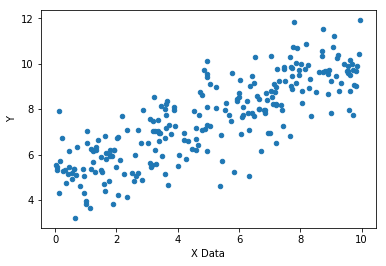

In [58]:
my_data.sample(n=250).plot(kind = 'scatter', x = 'X Data', y = 'Y')

In [59]:
# First create variables
# Second create placeholders
# A placeholder is simply a variable that we will assign data to at a later date. 
# It allows us to create our operations and build our computation graph without needing the data
# Third Define graph

batch_size = 10
m = tf.Variable(0.2)
b = tf.Variable(700.0) # need to declare as float: "20" won't work!
xph = tf.placeholder(tf.float32, [batch_size])
yph = tf.placeholder(tf.float32, [batch_size])

y_model = m*xph + b # Graph that I'm trying to compute

# Create loss function
error = tf.reduce_sum(tf.square(yph - y_model)) # (stuff)**2 is acceptable too

# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

In [60]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    batches = 50000
    for i in range(batches):
        rand_ind = np.random.randint(len(x_data), size = batch_size)
        feed = {xph: x_data[rand_ind], yph: y_true[rand_ind]}
        sess.run(train, feed_dict = feed)
        
        model_m, model_b = sess.run([m,b])

0.49859524 4.9761977


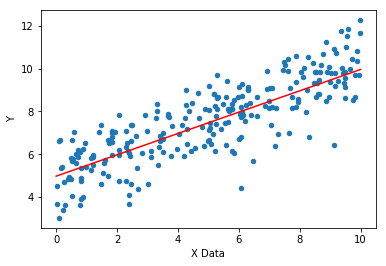

In [61]:
y_hat = x_data*model_m + model_b
my_data.sample(250).plot(kind='scatter', x = 'X Data', y='Y')
plt.plot(x_data, y_hat, 'r')
print(model_m, model_b)

### Alternative method using tf.estimator

In [62]:
feat_cols = [tf.feature_column.numeric_column('x', shape=[1])] # 1 feature column
estimator = tf.estimator.LinearRegressor(feature_columns= feat_cols)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\User\\AppData\\Local\\Temp\\tmp6y963991', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000024419FED438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [63]:
from sklearn.model_selection import train_test_split
x_train, x_eval, y_train, y_eval = train_test_split(x_data, y_true, test_size = 0.3, random_state = 101)
print(x_train.shape, x_eval.shape)

(700000,) (300000,)


In [64]:
input_func = tf.estimator.inputs.numpy_input_fn({'x': x_train}, y_train, batch_size = 10, num_epochs=None, shuffle=True)
train_input_func = tf.estimator.inputs.numpy_input_fn({'x': x_train}, y_train, batch_size = 10, num_epochs=1000, shuffle=False)
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x': x_eval}, y_eval, batch_size = 10, num_epochs=1000, shuffle=False)

estimator.train(input_fn=input_func, steps = 1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\User\AppData\Local\Temp\tmp6y963991\model.ckpt.
INFO:tensorflow:loss = 443.22882, step = 1
INFO:tensorflow:global_step/sec: 275.524
INFO:tensorflow:loss = 13.071096, step = 101 (0.368 sec)
INFO:tensorflow:global_step/sec: 411.756
INFO:tensorflow:loss = 22.320688, step = 201 (0.237 sec)
INFO:tensorflow:global_step/sec: 469.919
INFO:tensorflow:loss = 8.6667595, step = 301 (0.226 sec)
INFO:tensorflow:global_step/sec: 288
INFO:tensorflow:loss = 32.786938, step = 401 (0.342 sec)
INFO:tensorflow:global_step/sec: 487.875
INFO:tensorflow:loss = 6.927233, step = 501 (0.201 sec)
INFO:tensorflow:global_step/sec: 557.398
INFO:tensorflow:loss = 6.1263247, step = 601 (0.178 sec)
INFO:tensorflow:global_step/sec: 2

In [65]:
# this time, specify "train_input_func" in order to prevent shuffling
# so that everything is in the same order
train_metrics = estimator.evaluate(input_fn = train_input_func, steps = 10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-23-13:05:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\User\AppData\Local\Temp\tmp6y963991\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1000/10000]
INFO:tensorflow:Evaluation [2000/10000]
INFO:tensorflow:Evaluation [3000/10000]
INFO:tensorflow:Evaluation [4000/10000]
INFO:tensorflow:Evaluation [5000/10000]
INFO:tensorflow:Evaluation [6000/10000]
INFO:tensorflow:Evaluation [7000/10000]
INFO:tensorflow:Evaluation [8000/10000]
INFO:tensorflow:Evaluation [9000/10000]
INFO:tensorflow:Evaluation [10000/10000]
INFO:tensorflow:Finished evaluation at 2018-07-23-13:05:58
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.0538104, global_step = 1000, loss = 10.538103
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C

In [66]:
eval_metrics = estimator.evaluate(input_fn = eval_input_func, steps = 10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-23-13:05:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\User\AppData\Local\Temp\tmp6y963991\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1000/10000]
INFO:tensorflow:Evaluation [2000/10000]
INFO:tensorflow:Evaluation [3000/10000]
INFO:tensorflow:Evaluation [4000/10000]
INFO:tensorflow:Evaluation [5000/10000]
INFO:tensorflow:Evaluation [6000/10000]
INFO:tensorflow:Evaluation [7000/10000]
INFO:tensorflow:Evaluation [8000/10000]
INFO:tensorflow:Evaluation [9000/10000]
INFO:tensorflow:Evaluation [10000/10000]
INFO:tensorflow:Finished evaluation at 2018-07-23-13:06:18
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.0553074, global_step = 1000, loss = 10.553074
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C

In [67]:
print(train_metrics,'\n', eval_metrics)

{'average_loss': 1.0538104, 'loss': 10.538103, 'global_step': 1000} 
 {'average_loss': 1.0553074, 'loss': 10.553074, 'global_step': 1000}


In [68]:
brand_new_data = np.linspace(0,10,10)
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x': brand_new_data}, shuffle = False)
list(estimator.predict(input_fn = input_fn_predict))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\User\AppData\Local\Temp\tmp6y963991\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'predictions': array([4.5377812], dtype=float32)},
 {'predictions': array([5.1649156], dtype=float32)},
 {'predictions': array([5.7920494], dtype=float32)},
 {'predictions': array([6.4191837], dtype=float32)},
 {'predictions': array([7.046318], dtype=float32)},
 {'predictions': array([7.673452], dtype=float32)},
 {'predictions': array([8.300587], dtype=float32)},
 {'predictions': array([8.927721], dtype=float32)},
 {'predictions': array([9.554855], dtype=float32)},
 {'predictions': array([10.181989], dtype=float32)}]

In [69]:
predictions = []
for pred in estimator.predict(input_fn = input_fn_predict):
    predictions.append(pred['predictions'])
    
predictions

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\User\AppData\Local\Temp\tmp6y963991\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[array([4.5377812], dtype=float32),
 array([5.1649156], dtype=float32),
 array([5.7920494], dtype=float32),
 array([6.4191837], dtype=float32),
 array([7.046318], dtype=float32),
 array([7.673452], dtype=float32),
 array([8.300587], dtype=float32),
 array([8.927721], dtype=float32),
 array([9.554855], dtype=float32),
 array([10.181989], dtype=float32)]

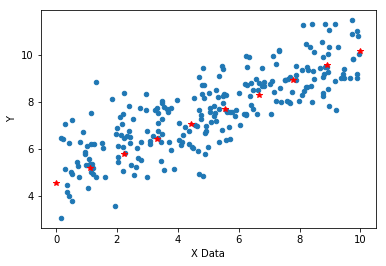

In [70]:
my_data.sample(n=250).plot(kind = 'scatter', x='X Data', y= 'Y')
plt.plot(brand_new_data, predictions, 'r*')